# Hello!
Welcome to my notebook for the "Classification with a Tabular Vector Borne Disease Dataset" playground competition on Kaggle. To summarize the dataset, symptoms of diseases are the categorical variables, each being true or false depending on whether the patient experienced that symptom or not. You are trying to classify each sample with one of 11 diseases. For each test sample, you are allowed to make up to 3 predictions. Original competition: https://www.kaggle.com/competitions/playground-series-s3e13.

# Import Libraries

In [1]:
import numpy as np
import pandas as pd

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier

# Metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import balanced_accuracy_score

# Encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

# Optimization
import optuna

# EDA
import seaborn as sns
import matplotlib.pyplot as plt

c:\Users\andar\VSC Projects\.venv\Lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import Data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

X = train.drop(['id', 'prognosis'], axis=1)
y = train['prognosis']

X_test = test.drop(['id'], axis=1)

# Missing Data

In [3]:
for col in train.columns:
    num_missing_values = train[col].isna().sum()
    print(f'{col} is missing {num_missing_values} values')

id is missing 0 values
sudden_fever is missing 0 values
headache is missing 0 values
mouth_bleed is missing 0 values
nose_bleed is missing 0 values
muscle_pain is missing 0 values
joint_pain is missing 0 values
vomiting is missing 0 values
rash is missing 0 values
diarrhea is missing 0 values
hypotension is missing 0 values
pleural_effusion is missing 0 values
ascites is missing 0 values
gastro_bleeding is missing 0 values
swelling is missing 0 values
nausea is missing 0 values
chills is missing 0 values
myalgia is missing 0 values
digestion_trouble is missing 0 values
fatigue is missing 0 values
skin_lesions is missing 0 values
stomach_pain is missing 0 values
orbital_pain is missing 0 values
neck_pain is missing 0 values
weakness is missing 0 values
back_pain is missing 0 values
weight_loss is missing 0 values
gum_bleed is missing 0 values
jaundice is missing 0 values
coma is missing 0 values
diziness is missing 0 values
inflammation is missing 0 values
red_eyes is missing 0 values
l

# Categorical Data

In [4]:
all_classes = []

s = set()
for val in train['prognosis']:
    s.add(val)

print("All classes:")
for i in s:
    all_classes.append(i)
    print(i)

All classes:
Japanese_encephalitis
West_Nile_fever
Malaria
Tungiasis
Chikungunya
Plague
Lyme_disease
Yellow_Fever
Dengue
Zika
Rift_Valley_fever


# Ordinal Encoding

In [5]:
def ordinal_encode(data, inverse=False):
    ordinal_encoder = {
        'Malaria':0,
        'West_Nile_fever':1,
        'Lyme_disease':2,
        'Plague':3,
        'Tungiasis':4,
        'Japanese_encephalitis':5,
        'Chikungunya':6,
        'Zika':7,
        'Yellow_Fever':8,
        'Dengue':9,
        'Rift_Valley_fever':10
    }
    
    inverse_ordinal_encoder={}
    
    for k,v in ordinal_encoder.items():
        print(f'k{k}  v{v}')
        inverse_ordinal_encoder[v]=k
    
    if(inverse==False):
        for i in range(0, len(data)):
            data[i]=ordinal_encoder[data[i]];
        
    else:
        for i in range(0, len(data)):
            data[i]=inverse_ordinal_encoder[data[i]]
            
    return data

# One-Hot Encoding

In [6]:
def OH_encode(data, column):
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    OH_train = pd.DataFrame(OH_encoder.fit_transform(data[[column]]))  # fit_transform only works for 2D dataframes, so by adding extra square brackets turns 2D
    OH_train.index = data.index
    
    return OH_train

# Convert Categorical Variables

In [7]:
# ONE HOT ENCODING (for heatmap):
OH_columns = OH_encode(train, 'prognosis')
OH_data = pd.concat([train.drop(['id', 'prognosis'], axis=1), OH_columns], axis=1)

for i, aClass in enumerate(all_classes):
    OH_data[aClass]=OH_data[i]

OH_data.drop([i for i in range(11)], axis=1, inplace=True)

# X = pd.concat([train.drop(['id', 'prognosis'], axis=1), OH_columns], axis=1)

# display(OH_columns)

# display(train.columns)
# display(train['prognosis'])

# print('All unique values in "prognosis" column:', train['prognosis'].unique())



# ORDINAL ENCODING:
# ordinal_encoder=OrdinalEncoder()
# y2=ordinal_encoder.fit_transform([y])  # series must be inside array
# y2=pd.Series(y2[0])  # to get series, not entire 2D array
# y2=ordinal_encode(y)
# y2=y2.astype('int')  # y2 is originally of type object, so sklearn cannot recognize type



# NO ENCODING:
y2=y

c:\Users\andar\VSC Projects\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# EDA
As you can see from the heatmap below, there is very little (direct) correlation between most symptoms and most prognosis.

Frequency of each class


{'Lyme_disease': 52,
 'Tungiasis': 70,
 'Zika': 58,
 'Rift_Valley_fever': 70,
 'West_Nile_fever': 85,
 'Malaria': 48,
 'Chikungunya': 66,
 'Plague': 53,
 'Dengue': 63,
 'Yellow_Fever': 61,
 'Japanese_encephalitis': 81}

([<matplotlib.patches.Wedge at 0x1d70e1b6310>,
 [Text(1.0707654024966358, 0.2519155668398002, 'Lyme_disease'),
  Text(0.7872639162376409, 0.7682548575766852, 'Tungiasis'),
  Text(0.24953596014617319, 1.071322455936553, 'Zika'),
  Text(-0.3667651622145618, 1.0370551170433162, 'Rift_Valley_fever'),
  Text(-0.9422821109683054, 0.567542441892335, 'West_Nile_fever'),
  Text(-1.0986862194005624, -0.05374561655893023, 'Malaria'),
  Text(-0.9346328760000584, -0.5800529174996534, 'Chikungunya'),
  Text(-0.5143555483923424, -0.9723365517340242, 'Plague'),
  Text(0.03176705028999929, -1.0995412018273225, 'Dengue'),
  Text(0.6027194561212511, -0.9201789267381119, 'Yellow_Fever'),
  Text(1.029514472930789, -0.3874273480615942, 'Japanese_encephalitis')],
 [Text(0.5840538559072558, 0.13740849100352737, '7%'),
  Text(0.42941668158416774, 0.41904810413273735, '10%'),
  Text(0.13611052371609444, 0.5843577032381198, '8%'),
  Text(-0.20005372484430642, 0.5656664274781724, '10%'),
  Text(-0.513972060528166

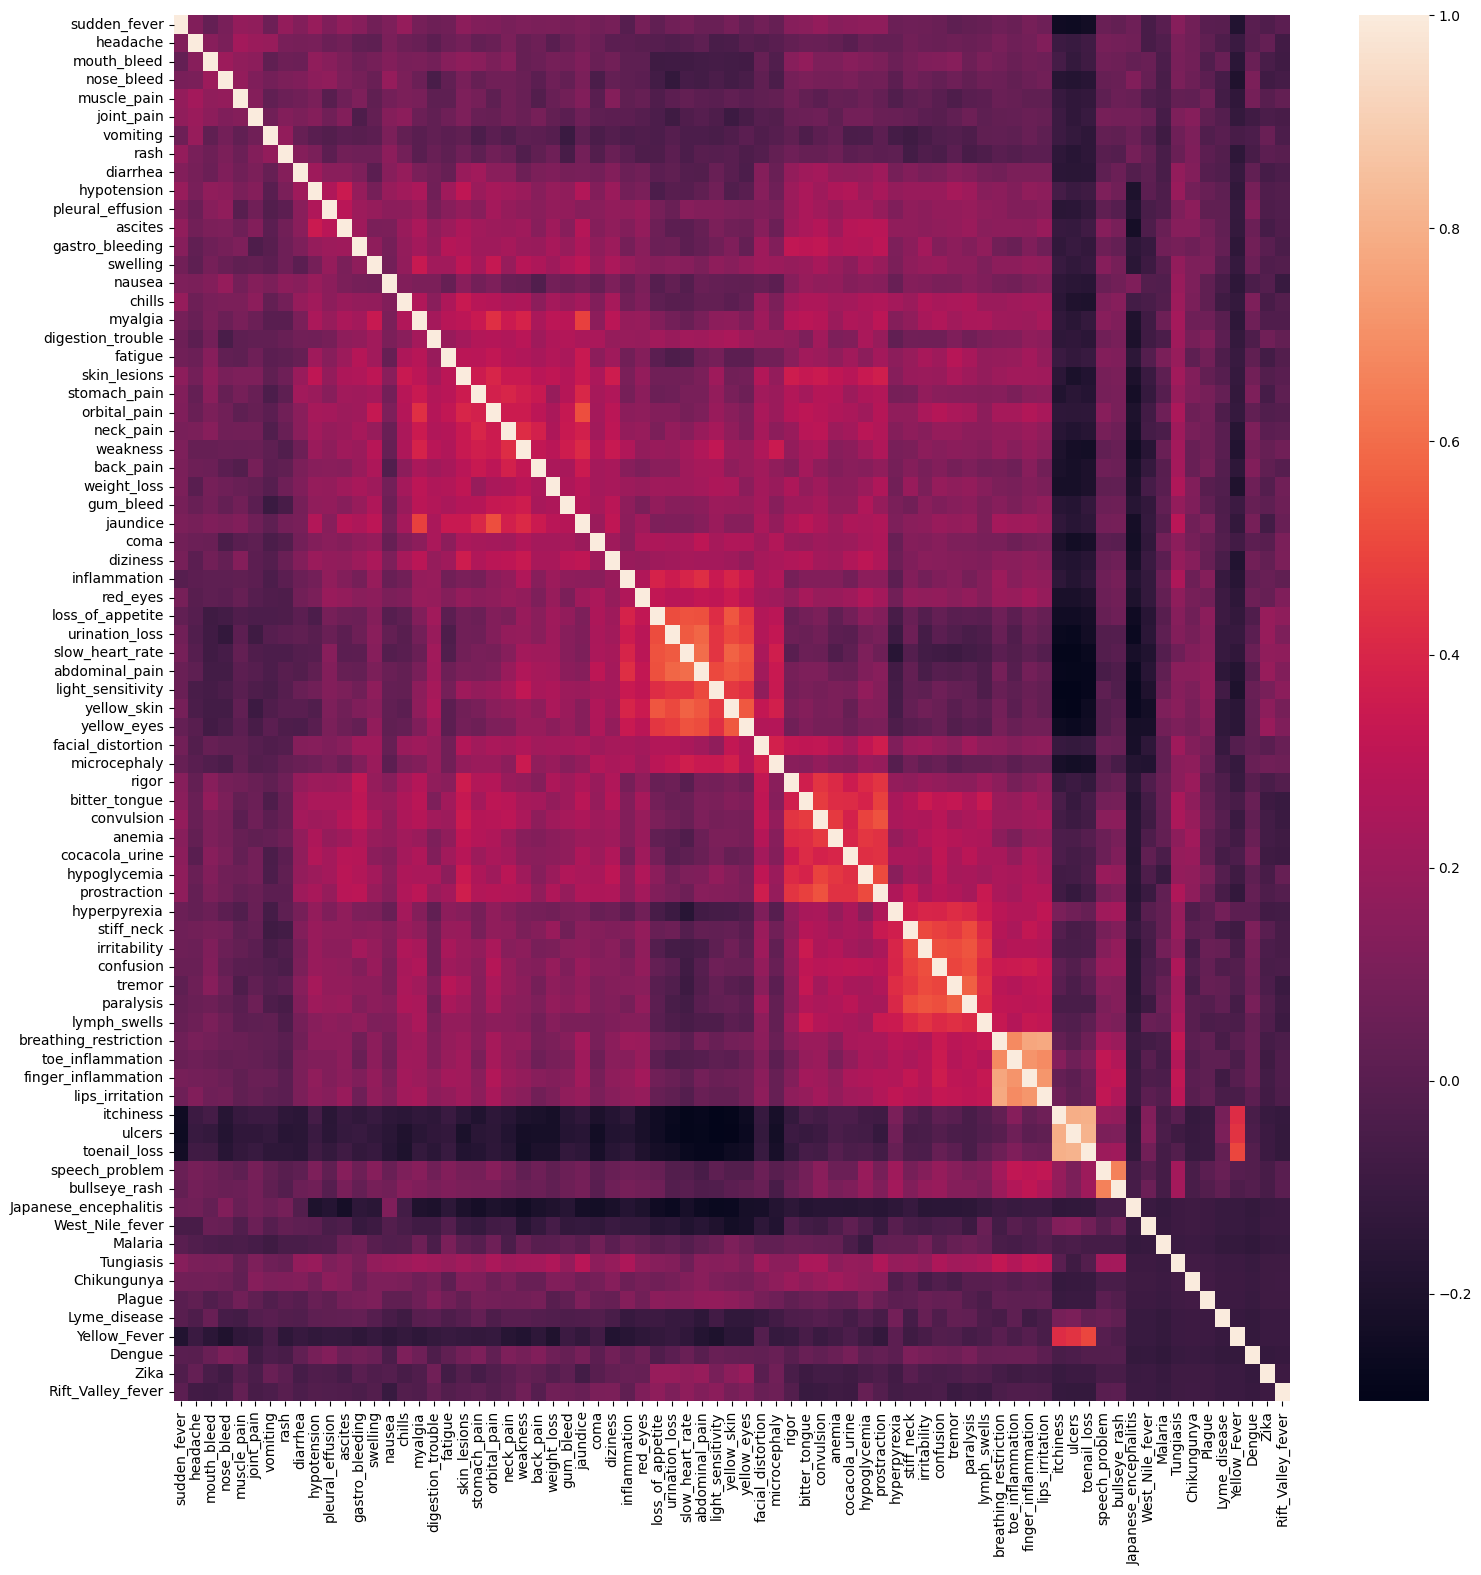

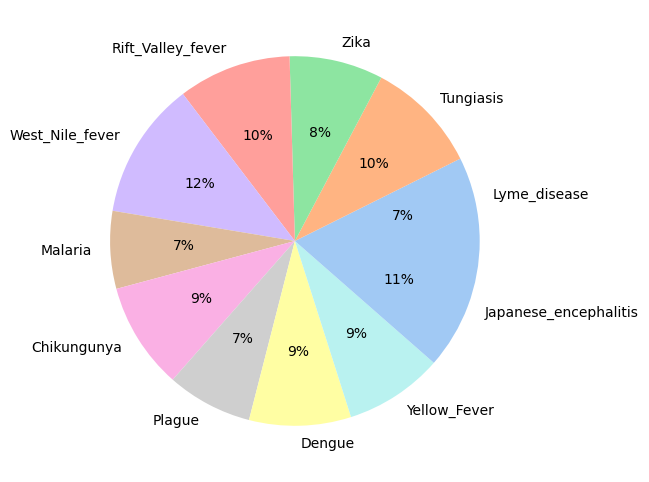

In [8]:
# Frequency of each prognosis value
unique_prognosis_vals = train['prognosis'].unique()
prog_vals_freq = {}
for i in unique_prognosis_vals:
    prog_vals_freq[i]=0

for i in range(0, len(train['prognosis'])):
    prog_vals_freq[train['prognosis'][i]]+=1

print("Frequency of each class")    
display(prog_vals_freq)



# Heatmap:
# Note: Heatmap with "prognosis" classes is only possible if they are encoded
plt.figure(figsize=(18, 18))
sns.heatmap(OH_data.corr(numeric_only=False))



# Pie graph:
plt.figure(figsize=(12, 6))
frequencies=[]
for i in unique_prognosis_vals:
    frequencies.append(prog_vals_freq[i])
colors = sns.color_palette('pastel')[0:11]

plt.pie(frequencies, labels=unique_prognosis_vals, colors=colors, autopct='%.0f%%')

# RandomForestClassifier

In [9]:
def study_rfc(X, y):
    def objective(trial):
        # For RandomForestClassifier
        n_estimators = trial.suggest_int('n_estimators', 10, 500)
        max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 100)
        max_depth = trial.suggest_int('max_depth', 1, 30)
        
        rf = RandomForestClassifier(n_estimators=n_estimators,
                        max_leaf_nodes=max_leaf_nodes,
                        max_depth=max_depth)


        # Cross Validation
        # score = cross_val_score(rf, X, y, n_jobs=4, cv=5 , scoring='accuracy', error_score='raise')
        # return score.mean()
        
        # Repeated Stratified KFold
        kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=69);
        scores = cross_val_score(rf, X, y, cv=kfold, n_jobs=4)
        return np.mean(scores)
        
        # scores = []
        
        # for train_idx, test_idx in kfold.split(X, y):
        #     display(train_idx)
        #     display(test_idx)
        #     display(X[X.columns][train_idx])
        #     X_train, X_test = X[X.columns][train_idx], X[X.columns][test_idx]
        #     y_train, y_test = y[y.columns][train_idx], y[y.columns][test_idx]
        #     rf.fit(X_train, y_train)
        #     y_pred = rf.predict(X_test)
        #     scores.append(balanced_accuracy_score(y_test, y_pred))
        
        # return np.mean(scores)

        

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)
    
    return study.best_params, study.best_value

best_params_rfc, best_value_rfc = study_rfc(X, y2)
print(f'best_params_rfc: {best_params_rfc}')
print(f'best_value_rfc: {best_value_rfc}')

[I 2023-07-01 23:13:17,509] A new study created in memory with name: no-name-31592096-2321-42e4-94d9-17f9a55e26c5


[I 2023-07-01 23:13:30,637] Trial 0 finished with value: 0.3036217303822938 and parameters: {'n_estimators': 296, 'max_leaf_nodes': 67, 'max_depth': 5}. Best is trial 0 with value: 0.3036217303822938.
[I 2023-07-01 23:13:31,835] Trial 1 finished with value: 0.24044936284372903 and parameters: {'n_estimators': 74, 'max_leaf_nodes': 49, 'max_depth': 1}. Best is trial 0 with value: 0.3036217303822938.
[I 2023-07-01 23:13:38,041] Trial 2 finished with value: 0.2833534540576794 and parameters: {'n_estimators': 349, 'max_leaf_nodes': 5, 'max_depth': 2}. Best is trial 0 with value: 0.3036217303822938.
[I 2023-07-01 23:13:41,863] Trial 3 finished with value: 0.2441851106639839 and parameters: {'n_estimators': 155, 'max_leaf_nodes': 10, 'max_depth': 1}. Best is trial 0 with value: 0.3036217303822938.
[I 2023-07-01 23:13:46,451] Trial 4 finished with value: 0.3082964453386988 and parameters: {'n_estimators': 123, 'max_leaf_nodes': 72, 'max_depth': 22}. Best is trial 4 with value: 0.3082964453386

best_params_rfc: {'n_estimators': 320, 'max_leaf_nodes': 42, 'max_depth': 19}
best_value_rfc: 0.31680080482897394


# XGBClassifier

In [10]:
def study_xgbc(X, y):
    def objective(trial):
        # For XGBClassifier
        n_estimators = trial.suggest_int('n_estimators', 10, 250)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
        max_depth = trial.suggest_int('max_depth', 1, 30)
        
        xgb = XGBClassifier(n_estimators=n_estimators,
                        learning_rate=learning_rate,
                        max_depth=max_depth)

        score = cross_val_score(xgb, X, y, n_jobs=4, cv=5, error_score='raise')
        
        return score.mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)
    
    return study.best_params, study.best_value

best_params_xgbc, best_value_xgbc = study_xgbc(X, y2)
print(f'best_params_xgbc: {best_params_xgbc}')
print(f'best_value_xgbc: {best_value_xgbc}')

[I 2023-07-01 23:18:12,833] A new study created in memory with name: no-name-41421d7f-772b-42b6-b18c-e6d689c81421
[W 2023-07-01 23:18:16,250] Trial 0 failed with parameters: {'n_estimators': 62, 'learning_rate': 0.06260726538657482, 'max_depth': 19} because of the following error: ValueError("Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10], got ['Chikungunya' 'Dengue' 'Japanese_encephalitis' 'Lyme_disease' 'Malaria'\n 'Plague' 'Rift_Valley_fever' 'Tungiasis' 'West_Nile_fever' 'Yellow_Fever'\n 'Zika']").
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "c:\Users\andar\VSC Projects\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py", line 436, in _process_worker
    r = call_item()
        ^^^^^^^^^^^
  File "c:\Users\andar\VSC Projects\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py", line 288, in __call__
    return self.fn(*self.args, **self.kwargs)

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10], got ['Chikungunya' 'Dengue' 'Japanese_encephalitis' 'Lyme_disease' 'Malaria'
 'Plague' 'Rift_Valley_fever' 'Tungiasis' 'West_Nile_fever' 'Yellow_Fever'
 'Zika']

# KNeighborsClassifier

In [ ]:
def study_knc(X, y):
    def objective(trial):
        # For KNeighborsClassifier
        n_neighbors = trial.suggest_int('n_neighbors', 10, 100)
        leaf_size = trial.suggest_int('leaf_size', 1, 500)
        p = trial.suggest_int('p', 1, 5)
        
        kn = KNeighborsClassifier(n_neighbors=n_neighbors,
                        leaf_size=leaf_size,
                        p=p)

        score = cross_val_score(kn, X, y, n_jobs=4, cv=5, error_score='raise')
        
        return score.mean()

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)
    
    return study.best_params, study.best_value

best_params_knc, best_value_knc = study_knc(X, y2)
print(f'best_params_knc: {best_params_knc}')
print(f'best_value_knc: {best_value_knc}')

# LGBMClassifier

In [ ]:
def study_lgbm(X, y):
    def objective(trial):
        # For LGBMClassifier
        num_leaves = trial.suggest_int('num_leaves', 10, 500)
        max_depth = trial.suggest_int('max_depth', -1, 50)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.5)
        n_estimators = trial.suggest_int('n_estimators', 1, 1000)
        random_state = 69
        # consider class_weight
        
        
        lgbm = LGBMClassifier(
            num_leaves=num_leaves,
            max_depth=max_depth,
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            random_state=random_state
        )

        score = cross_val_score(lgbm, X, y, n_jobs=4, cv=5, error_score='raise')
        
        return score.mean()

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)
    
    return study.best_params, study.best_value

best_params_lgbm, best_value_lgbm = study_lgbm(X, y2)
print(f'best_params_lgbm: {best_params_lgbm}')
print(f'best_value_lgbm: {best_value_lgbm}')

# Submission

In [ ]:
# Single prediction
final_model = RandomForestClassifier(
    n_estimators=best_params_rfc['n_estimators'],
    max_leaf_nodes=best_params_rfc['max_leaf_nodes'],
    max_depth=best_params_rfc['max_depth'],
    n_jobs=4
)

final_model.fit(X, y2)

predictions = final_model.predict(X_test)

display(predictions)

submission = pd.DataFrame({'id':test.id, 'prognosis':predictions})

display(submission)

submission.to_csv('submission3.csv', index=False)

array(['Rift_Valley_fever', 'Chikungunya', 'West_Nile_fever',
       'Japanese_encephalitis', 'Malaria', 'Yellow_Fever', 'Malaria',
       'Chikungunya', 'Yellow_Fever', 'West_Nile_fever',
       'West_Nile_fever', 'Rift_Valley_fever', 'Rift_Valley_fever',
       'Chikungunya', 'West_Nile_fever', 'Japanese_encephalitis',
       'West_Nile_fever', 'Tungiasis', 'Chikungunya', 'West_Nile_fever',
       'Malaria', 'Yellow_Fever', 'Japanese_encephalitis', 'Malaria',
       'Chikungunya', 'Chikungunya', 'Chikungunya', 'Yellow_Fever',
       'Yellow_Fever', 'Lyme_disease', 'Yellow_Fever', 'Tungiasis',
       'Lyme_disease', 'Lyme_disease', 'Lyme_disease', 'West_Nile_fever',
       'Japanese_encephalitis', 'Yellow_Fever', 'Lyme_disease',
       'West_Nile_fever', 'West_Nile_fever', 'Chikungunya',
       'Yellow_Fever', 'Yellow_Fever', 'Chikungunya', 'Rift_Valley_fever',
       'Chikungunya', 'Lyme_disease', 'Yellow_Fever', 'Tungiasis',
       'Rift_Valley_fever', 'Chikungunya', 'Lyme_disease',

,id,prognosis
0,707,Rift_Valley_fever
1,708,Chikungunya
2,709,West_Nile_fever
3,710,Japanese_encephalitis
4,711,Malaria
...,...,...
298,1005,Yellow_Fever
299,1006,Malaria
300,1007,West_Nile_fever
301,1008,West_Nile_fever
